In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
import sys

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from IHANKModel import IHANKModelClass
import figures 
import calculations

run_test = False
path = '/Users/emmagundersen/Desktop/Current code/I_HANK_PIG/fig/0403/'
lvl_path = ['U_hh', 'Walras', 'CB', 'i', 'NX', 'CA', 'ra', 'iF_s',  'iF_s']
path_philips= ['WTH', 'WNT', 'NTH', 'NNT', 'PTH', 'PNT', 'PF', 'UC_TH_hh', 'UC_NT_hh', 'EX']
paths = ['PE_s', 'PE', 'YH',  'W', 'P', 'w', 'tau',  'N', 'INC', 'inc',  'CT', 'CNT', 'p', 'E', 'PF_s', 'PF', 'CTH_s', 'i', 'ra', 'iF_s']




In [2]:
model = IHANKModelClass(name='baseline')
model.par.nu = 2.0
model.par.eta_s = 0.5 
model.par.etaF = 0.5
model.par.etaE = 0.1
model.par.gamma_ = model.par.epsilon_
# model.par.epsilon_ = 0.0 # for homothetic preferences
model.par.float = True
model.par.pf_fixed = False
model.par.mon_policy = 'real'
model.par.phi_inflation = 1.0

model.find_ss(do_print=False)
model.compute_jacs()

shock_PE_s, shock_forigne_interest, shock_PF_s, shock_PF_s_taylor, shock_PE_PF, shock_PE_PF_taylor, shock_i = calculations.difine_shocks(model) 

Share of domestic workers in tradable sector = 0.50


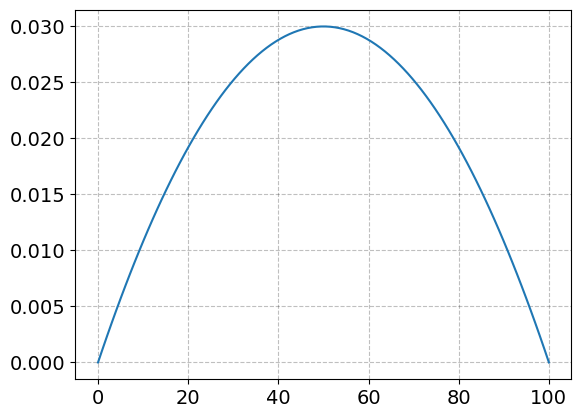

In [28]:
def concave_function(x):
    return -0.000012 * (x - 50)**2  + 0.000012 * (50)**2

# Generate x values
x = np.linspace(0,  100, 100)
y = concave_function(x)

# Plot the function
plt.plot(x, y, label='Concave Function')
# 





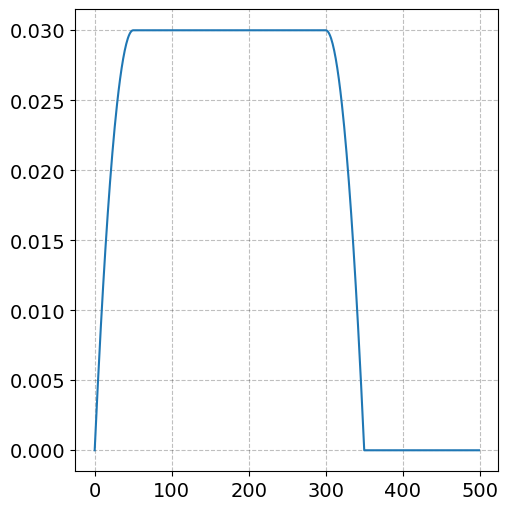

In [40]:
pi = np.zeros(model.par.T) # 
T_max = model.par.T//2     


width = 0.000012


PE_calc = np.zeros(model.par.T)

# Prices
for t in range(50):
    if t==0:
        PE_calc[t] = 0.0
    else:
        PE_calc[t] = -0.000012 * (t - 50)**2 + + 0.000012 * (50)**2

for t in range(50, 300):
    PE_calc[t] = 0.03

for t in range(300, model.par.T):
    i = t-250
    PE_calc[t] = -0.000012 * (i - 50)**2  + 0.000012 * (50)**2

PE_calc = np.fmax(PE_calc, 0.0)

# # Falling phase: smooth decrease (inverse of the rising phase)
# for t in range(T_max, model.par.T):
#     pi[t] = +scale * (rho ** (t - T_max))
#     PE_calc[t] = PE_calc[t-1] * (1 - pi[t])


dPE_s = PE_calc#- model.ss.PE_s

# dPE_s[100:model.par.T] = 0

fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 2, 1)
ax.plot(dPE_s, label='dPE_s')

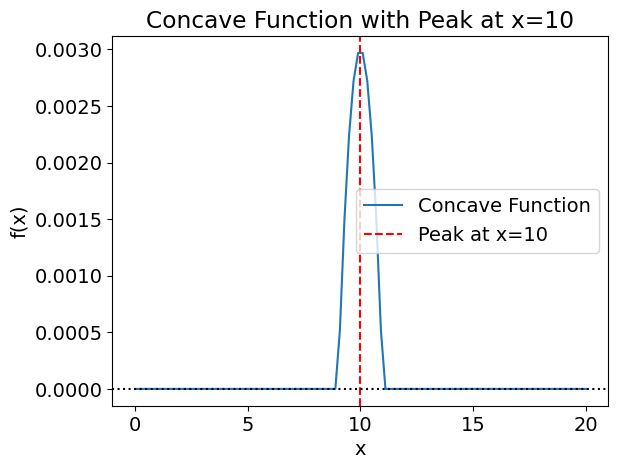

In [51]:
import numpy as np
import matplotlib.pyplot as plt

peak = 0.003
Tpeak = 10

def concave_function(x):
    return np.fmax(-peak * (x - Tpeak)**2 + peak,0)




# Generate x values
x = np.linspace(0, 20, 100)
y = concave_function(x)

# Plot the function
plt.plot(x, y, label='Concave Function')
plt.axvline(10, color='r', linestyle='--', label='Peak at x=10')
plt.axhline(0, color='k', linestyle=':')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Concave Function with Peak at x=10')
plt.legend()
plt.grid()
plt.show()


